In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import measurements
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
from collections import deque
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
class Tracker():
    # class to create and store information of vehicle detections on an image or a series of images
    def __init__(self, classifier, feature_extractor, features_scaler, scale_dict, max_to_keep = 1,
                 heat_threshold=0, single_threshold=None, init_size=(64,64), step=0.125, nms_overlap=0.01,
                cvt_bgr=True):
        self.clf = classifier
        self.feature_extractor = feature_extractor
        self.scaler = features_scaler
        self.heatmaps = None
        self.max_to_keep = max_to_keep
        self.heat_threshold = heat_threshold
        self.single_threshold = single_threshold
        self.init_size = init_size
        self.step = step
        self.scale_dict = scale_dict
        self.heat_deque = deque([], self.max_to_keep)
        self.nms_overlap = nms_overlap
        self.cvt_bgr = cvt_bgr

        
    def track(self, img_, video_mode=True):
        if self.cvt_bgr:
            img = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
        else:
            img = img_.copy()
        heatmaps, _, _ = self.detect_multiscale(img, self.scale_dict,
                        init_size=self.init_size, step=self.step, return_images=False)
        multiscale_heatmap, _, draw_img = self.draw_multiscale(img, heatmaps, self.single_threshold)
        
        if video_mode:
            self.heat_deque.append(multiscale_heatmap)
            sum_heat = np.zeros_like(multiscale_heatmap)
            for h in self.heat_deque:
                sum_heat += h
            multiscale_heatmap, _, draw_img = self.draw_multiscale(img, sum_heat, min(max(0,len(self.heat_deque)-1),
                                                                                      self.heat_threshold))

        return draw_img
                
    def sum_with_threshold(self, heatmaps, threshold):
        sum_heat = np.sum(heatmaps, axis=0)
        sum_heat[sum_heat<=threshold] = 0
        return sum_heat
        
        
    def draw_multiscale(self, img, heatmaps_, threshold=None):
        draw_img = img.copy()
        heatmaps = heatmaps_.copy()
        if threshold is not None:
            heatmaps[heatmaps<=threshold]=0
        ones_heatmap = np.zeros_like(heatmaps)
        ones_heatmap[heatmaps>0] = 1
        labeled_map, labels = measurements.label(ones_heatmap)
        multiscale_heatmap = np.zeros_like(heatmaps)
        multiscale_bboxes = []
        for label_ in range(labels):
            yc, xc, sw = 0, 0, 0
            x_s, y_s = [], []
            selection = labeled_map.copy()
            selection[selection != (label_+1)] = 0
            rows, cols = np.nonzero(selection)
            pts = np.array([rows,cols]).T
            for pt in pts:
                w = heatmaps[pt[0], pt[1]]
                yc += pt[0]*w
                xc += pt[1]*w
                x_s.append(pt[1])
                y_s.append(pt[0])
                sw += w
            yc /= sw
            xc /= sw
            xmin = min(x_s)
            xmax = max(x_s)
            ymin = min(y_s)
            ymax = max(y_s)
            w_2 = min(abs(xmin-xc), abs(xmax-xc))
            h_2 = min(abs(ymin-yc), abs(ymax-yc))
            x1 = int(max(0,xc-w_2))
            x2 = int(min(img.shape[1], xc+w_2))
            y1 = int(max(0, yc-h_2))
            y2 = int(min(img.shape[0], yc+h_2))
            label_bbox = (x1,y1,x2,y2)
            multiscale_heatmap[y1:y2, x1:x2] = 1
            cv2.rectangle(draw_img, (x1,y1), (x2,y2), (0,255,0), 6)
            multiscale_bboxes.append(label_bbox)
        return multiscale_heatmap, multiscale_bboxes, draw_img
        
    def detect_multiscale(self, img, scale_dict, init_size, step, return_images=False):
        heatmaps = None
        draw_imgs = None
        bboxes_scaled = []
        for k,v in scale_dict.items():
            scale = k
            ymin, ymax, xmin, xmax = v
            heat, bbox, draw = self.detect_cars(img, ymin, ymax, xmin, xmax,
                                               init_size = init_size,
                                               scale = scale, 
                                               step = step)
            if heatmaps is None:
                heatmaps = heat
            else:
                heatmaps += heat
            if return_images:
                if draw_imgs is None:
                    draw_imgs = draw[np.newaxis]
                else:
                    draw_imgs = np.vstack([draw_imgs, draw[np.newaxis]])
            bboxes_scaled.append((scale,bbox))
        return heatmaps, bboxes_scaled, draw_imgs


    def detect_cars(self, img, ymin, ymax, xmin, xmax,
                    init_size=(64,64), scale=1, step=0.125, color=(0,255,0)):
        features = self.feature_extractor.return_sliding_features(img, ymin, ymax, xmin, xmax,
                                init_size, scale, step)
        try:
            scaled_features = self.scaler.transform(features)
            predictions = self.clf.predict(scaled_features)
        except ValueError:
            print(features)
        heatmap, bboxes, draw_img = self.draw_detections(img, ymin, ymax, xmin, xmax, predictions,
                                                         init_size, scale, step, color=color)
        return heatmap, bboxes, draw_img

    def draw_detections(self, img, ymin, ymax, xmin, xmax, predictions, init_size, scale, step, color=(0,255,0)):
        draw_img = img.copy()
        heatmap = np.zeros((img.shape[0], img.shape[1]))
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        pred = predictions.reshape(nsteps_y, nsteps_x)
        ywin = y_init*scale
        xwin = x_init*scale
        bboxes = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                car = pred[i,j]
                if car == 1:
                    x_start = int(xmin+j*x_init*scale*step)
                    x_end = int(x_start + xwin)
                    y_start = int(ymin + i*y_init*scale*step)
                    y_end =int(y_start+ywin)

                    bboxes.append((x_start, y_start, x_end, y_end))
        bboxes = np.array(bboxes, dtype='int')
        nms_bboxes = non_max_suppression_fast(bboxes, self.nms_overlap)
        for bbox in nms_bboxes:
            x_start, y_start, x_end, y_end = bbox
            cv2.rectangle(draw_img, (x_start, y_start), (x_end, y_end), color, 6)
            heatmap[y_start:y_end, x_start:x_end] = 1
        return heatmap, nms_bboxes, draw_img


In [3]:
from skimage.feature import hog
from sklearn.base import BaseEstimator

class FeatureExtractor(BaseEstimator):
    # class for feature extraction from an image for classification
    def __init__(self, feature_types=['HOG', 'SPAT', 'HIST'],
                 hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=9,
                hog_params=None,
                color_transform=None, spat_size=(32,32),
                hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256), hog_method='smart'):
        self.feature_types = feature_types
        self.hog_params = hog_params
        self.hog_pix_per_cell = hog_pix_per_cell
        self.hog_cell_per_block = hog_cell_per_block
        self.hog_orient = hog_orient
        self.color_transform = color_transform
        self.spat_size = spat_size
        self.hist_channels = hist_channels
        self.hist_nbins = hist_nbins
        self.hist_bins_range = hist_bins_range
        self.hog_method = hog_method
        
    def fit(self, X, y):
      
        return self
        
    
    def transform(self, X, y=None):
        return self.return_features_all(X)
        
        
    def return_features_all(self, class_imgs):
        class_features = None
        for img in class_imgs:
            features = np.array([], dtype=np.float64)
            for feature_type in self.feature_types:
                features_ = self.return_features(img, feature_type, self.hog_params,
                                                 self.color_transform,
                                                 self.hog_pix_per_cell, self.hog_cell_per_block, self.hog_orient,
                                                 True, False,
                                                 self.spat_size,
                                                 self.hist_channels, self.hist_nbins,
                                                 self.hist_bins_range) # the first element is feature vector anyway
                features=np.concatenate((features, features_.ravel()))
            if class_features is None:
                class_features = features[np.newaxis]
            else:
                class_features = np.vstack([class_features, features[np.newaxis]])
        return class_features
    
    def return_features(self, img, feature_type, hog_params=None, color_transform_flag=None,
                       hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=9,
                       hog_feature_vec=True, hog_vis=False,
                       spat_size=(32,32),
                       hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
        if feature_type == 'HOG':
            return self.return_hog(img, hog_params=hog_params,
                                  pix_per_cell=hog_pix_per_cell,
                                  cell_per_block=hog_cell_per_block, orient=hog_orient,
                                  feature_vec=hog_feature_vec, vis=hog_vis)
        elif feature_type == 'SPAT':
            return self.return_spat(img, color_transform=color_transform_flag,
                                   size=spat_size)
        elif feature_type == 'HIST':
            hist_features_joint, hist_features, bin_centers = self.return_hist(img, color_transform=color_transform_flag,
                                    channels=hist_channels, nbins=hist_nbins, bins_range=hist_bins_range)
            return hist_features_joint
        else:
            raise ValueError
            
    def return_hog(self, img__, hog_params=None,
                   pix_per_cell=8, cell_per_block=2, orient=9, feature_vec=True, vis=False):
        if hog_params is None:
            img = img__.copy()
        else:
            img = None
            for cmap, channels in hog_params:
                if cmap is None:
                    cimg = img__.copy()
                else:
                    cimg = cv2.cvtColor(img__, cmap)
                for channel in channels:
                    ch = cimg[:,:,channel]
                    ch = ch[:,:,np.newaxis]
                    if img is None:
                        img = ch
                    else:
                        img = np.dstack([img, ch])
        if vis:
            varray = None
        if img.ndim == 2:
            img = img[:,:, np.newaxis]

        hog_joint = None
        
        for i in range(img.shape[-1]):
            return_list = hog(img[...,i], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block),
                              block_norm= 'L2-Hys', transform_sqrt=False, 
                              visualise= vis, feature_vector= feature_vec)
            if not vis:
                hog_features = return_list
            else:
                hog_features = return_list[0]
            
            if hog_joint is None:
                hog_joint = np.array(hog_features)[np.newaxis]
            else:
                if feature_vec:
                    hog_joint = np.hstack([hog_joint, np.array(hog_features)[np.newaxis]])
                else:
                    hog_joint = np.vstack([hog_joint, hog_features[np.newaxis]])
            
            if vis:
                if varray is None:
                    varray = return_list[1][np.newaxis]
                else:
                    varray = np.vstack(varray, return_list[1][np.newaxis])
        if vis:
            return hog_joint, varray
        else:
            return hog_joint
        
    def return_spat(self, img, color_transform=None, size=(32, 32)):
        if color_transform is None:
            feature_image = img.copy()
        else:
            feature_image = cv2.cvtColor(img, color_transform)           
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, size).ravel().astype(np.float64)
        # Return the feature vector
        return np.array([features])
    
    def return_hist(self, img, color_transform=None, channels=[0], nbins=32, bins_range=(0, 256)):
        if color_transform is None:
            feature_image = img.copy()
        else:
            feature_image = cv2.cvtColor(img, color_transform)  
        # take an arbitrary channel for getting bin centers
        rhist = np.histogram(feature_image[:,:,0], bins=nbins, range=bins_range)
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = []
        for channel in channels:
            hist, _ = np.histogram(feature_image[:,:,channel], bins=nbins, range=bins_range)
            hist_features.append(hist)
        hist_features = np.array([hist_features])
        hist_features_joint = np.array(hist_features, dtype=np.float64).flatten()
        # Return the individual histograms, bin_centers and feature vector
        return hist_features_joint, hist_features, bin_centers

    def return_sliding_features(self, img, ymin, ymax, xmin, xmax, 
                            init_size=(64,64), scale=1, step=0.125):
        features = None
        for ftype in self.feature_types:
            if ftype == 'HOG':
                ft = self.return_sliding_hog(img, ymin, ymax, xmin, xmax,
                                       init_size=init_size, scale=scale, step=step,
                                    hog_params = self.hog_params,
                                       cell_size=self.hog_pix_per_cell, method=self.hog_method)
            elif ftype == 'SPAT':
                ft = self.return_sliding_spat(img, ymin, ymax, xmin, xmax, 
                                         init_size=init_size, scale=scale,
                                         step=step, color_transform=self.color_transform, spat_size=self.spat_size)
            elif ftype == 'HIST':
                ft = self.return_sliding_hist(img, ymin, ymax, xmin, xmax, 
                                         init_size=init_size, scale=scale, step=step,
                                         color_transform=self.color_transform, hist_channels=self.hist_channels,
                                         hist_nbins=self.hist_nbins, hist_bins_range=self.hist_bins_range)
            else:
                raise ValueError
            if features is None:
                features = ft
            else:
                features = np.hstack([features, ft])
        return features
    
    def return_sliding_hog(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1, step=0.125, cell_size=8,
                             hog_params=None, method='smart'):
        if method == 'smart':
            return self.return_sliding_hog_smart(img, ymin, ymax, xmin, xmax, init_size=init_size,
                                                 scale=scale, step=step, cell_size=cell_size,
                             hog_params=hog_params)
        else:
            return self.return_sliding_hog_simple(img, ymin, ymax, xmin, xmax, init_size=init_size,
                                                 scale=scale, step=step, cell_size=cell_size,
                             hog_params=hog_params)

    def return_sliding_hog_smart(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1, step=0.125, cell_size=8,
                             hog_params=None):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        delta_index_y = math.floor(step*y_init/cell_size)
        delta_index_x = math.floor(step*x_init/cell_size)
        dy_hog = y_init//cell_size - 1
        dx_hog = x_init//cell_size - 1
        resized_hog = self.return_features(resized_img, 'HOG', hog_params=hog_params, hog_feature_vec=False)
        window_features = []
        for i in range(nsteps_y):
            y_ind = i*delta_index_y
            for j in range(nsteps_x):
                x_ind = j*delta_index_x
                window_hog = np.array([], dtype=np.float64)
                for channel in range(resized_hog.shape[0]):
                    window_hog_ = resized_hog[channel, y_ind:(y_ind+dy_hog),x_ind:(x_ind+dx_hog),:]
                    window_hog = np.concatenate((window_hog, window_hog_.ravel()))
                window_features.append(window_hog)

        return np.array(window_features) #, np.array(window_imgs)
    
    def return_sliding_hog_simple(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1, step=0.125, cell_size=8,
                             hog_params=None):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        window_features = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
                resized_hog = self.return_features(window_img, 'HOG', hog_params=hog_params, hog_feature_vec=False)
                window_hog = np.array([], dtype=np.float64)
                for channel in range(resized_hog.shape[0]):
                    window_hog_ = resized_hog[channel,...]
                    window_hog = np.concatenate((window_hog, window_hog_.ravel()))
                window_features.append(window_hog)

        return np.array(window_features) #, np.array(window_imgs)

    def return_sliding_spat(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1,
                            step=0.125, color_transform=None, spat_size=(32,32)):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        window_features = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
                features = self.return_features(window_img, 'SPAT',
                                                            color_transform_flag=color_transform, spat_size=spat_size)[0]
                window_features.append(features)
        return np.array(window_features)

    def return_sliding_hist(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1,
                            step=0.125, color_transform=None,hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        window_features = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
                features = self.return_features(window_img, 'HIST',
                                                            color_transform_flag=color_transform,
                                                            hist_channels=hist_channels, hist_nbins=hist_nbins,
                                                            hist_bins_range=hist_bins_range)
                window_features.append(features)
        return np.array(window_features)
    

In [4]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]

	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

## Pipeline implementation

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#### Make Data

In [6]:
VEHICLES_PATH = './vehicles/vehicles/'
NONVEHICLES_PATH = './non-vehicles/non-vehicles/'
vehicle_files = [os.path.join(VEHICLES_PATH, x, y) for\
                 x in os.listdir(VEHICLES_PATH) for y in os.listdir(os.path.join(VEHICLES_PATH,x)) if y!='.DS_Store']
nonvehicle_files = [os.path.join(NONVEHICLES_PATH, x, y) for\
                 x in os.listdir(NONVEHICLES_PATH) if x!='.DS_Store'\
                    for y in os.listdir(os.path.join(NONVEHICLES_PATH,x)) if y!='.DS_Store']


X = None
y = np.array([], dtype=np.int)
for vf in vehicle_files:
    img = cv2.imread(vf)
    if X is None:
        X = img[np.newaxis]
    else:
        X = np.vstack([X,img[np.newaxis]])
    y = np.append(y, 1)
for nvf in nonvehicle_files:
    img = cv2.imread(nvf)
    X = np.vstack([X, img[np.newaxis]])
    y = np.append(y,0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14208, 64, 64, 3)
(3552, 64, 64, 3)
(14208,)
(3552,)


In [9]:
data = dict()
data['X_train'] = X_train
data['X_test'] = X_test
data['y_train'] = y_train
data['y_test'] = y_test

In [11]:
import pickle
pth = './data/train_data_X_y'
if not os.path.exists(pth):
    os.mkdir(pth)

with open(os.path.join(pth, 'data.p'), 'wb') as f:
    pickle.dump(data,f)

    

#### Gridsearch

In [18]:
feature_extractor = FeatureExtractor()
classifier = RandomForestClassifier(n_estimators=100)
scaler = StandardScaler()
pipeline = Pipeline([('fextr', feature_extractor),('scl', scaler), ('clf', classifier)])

In [19]:
kf = KFold(n_splits=3)
param_grid = {'fextr__feature_types':[['HOG', 'SPAT', 'HIST'], ['HOG', 'HIST']], 
             'fextr__hog_params': [[(cv2.COLOR_BGR2YCrCb,[0])],
                                   [(cv2.COLOR_BGR2RGB,[0])],
                                   [(cv2.COLOR_BGR2HLS,[0])],
                                   [(cv2.COLOR_BGR2RGB,[0,2])]
                                  ],
             'fextr__color_transform': [cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2HLS, cv2.COLOR_BGR2YCrCb],
             'fextr__hist_channels':[[0,1,2]],
             'fextr__hist_nbins':[32,64],
             'fextr__hist_bins_range':[(0,256)],
             'fextr__spat_size':[(16,16),(32,32)],
             'clf__criterion':['gini', 'entropy'],
             }
scorer = make_scorer(accuracy_score)
clf = RandomizedSearchCV(pipeline, param_grid, n_iter=16, cv=kf, scoring=scorer, verbose=2, n_jobs=12)
clf.fit(X_train, y_train)
best_p = clf.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] fextr__spat_size=(16, 16), fextr__hog_params=[(36, [0])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV] fextr__spat_size=(16, 16), fextr__hog_params=[(36, [0])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV] fextr__spat_size=(16, 16), fextr__hog_params=[(36, [0])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV] fextr__spat_size=(32, 32), fextr__hog_params=[(4, [0])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_tr

[CV]  fextr__spat_size=(16, 16), fextr__hog_params=[(4, [0, 2])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=36, clf__criterion=gini, total=28.2min
[CV] fextr__spat_size=(16, 16), fextr__hog_params=[(4, [0, 2])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV]  fextr__spat_size=(16, 16), fextr__hog_params=[(52, [0])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=52, clf__criterion=gini, total=19.3min
[CV] fextr__spat_size=(16, 16), fextr__hog_params=[(4, [0])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV]  fextr__spat

[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed: 62.4min


[CV]  fextr__spat_size=(16, 16), fextr__hog_params=[(52, [0])], fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=52, clf__criterion=entropy, total=19.5min
[CV] fextr__spat_size=(32, 32), fextr__hog_params=[(4, [0, 2])], fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV]  fextr__spat_size=(16, 16), fextr__hog_params=[(4, [0])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini, total=19.8min
[CV] fextr__spat_size=(32, 32), fextr__hog_params=[(4, [0, 2])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV]  f

[CV] fextr__spat_size=(32, 32), fextr__hog_params=[(52, [0])], fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV]  fextr__spat_size=(32, 32), fextr__hog_params=[(4, [0, 2])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini, total=45.5min
[CV] fextr__spat_size=(32, 32), fextr__hog_params=[(52, [0])], fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini 
[CV]  fextr__spat_size=(32, 32), fextr__hog_params=[(4, [0, 2])], fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini, total=45

[Parallel(n_jobs=12)]: Done  48 out of  48 | elapsed: 178.8min finished


#### Testing results

In [20]:
p = best_p
fx = p.named_steps['fextr']
cl = p.named_steps['clf']
sc = p.named_steps['scl']

In [ ]:
trans = dict()
trans['feature_extractor'] = fx
trans['classifier'] = cl
trans['scaler'] = sc
with open('./data/train_data_X_y/transformers.p', 'wb') as f:
    pickle.dump(trans, f)

In [9]:
with open('./data/train_data_X_y/transformers.p', 'rb') as f:
    trans = pickle.load(f)
fx=trans['feature_extractor']
cl=trans['classifier']
sc=trans['scaler']

In [22]:
X_features_test = fx.transform(X_test)
X_features_scaled = sc.transform(X_features_test)
preds = cl.predict(X_features_scaled)
print(accuracy_score(y_test, preds))

0.9929617117117117


In [23]:
fx

FeatureExtractor(color_transform=36, feature_types=['HOG', 'SPAT', 'HIST'],
         hist_bins_range=(0, 256), hist_channels=[0, 1, 2], hist_nbins=64,
         hog_cell_per_block=2, hog_method='smart', hog_orient=9,
         hog_params=[(4, [0, 2])], hog_pix_per_cell=8, spat_size=(32, 32))

In [10]:
tracker = Tracker(cl, fx, sc, scale_dict={1:(360,550,300,1280), 1.5:(360,550,300,1280), 2:(360,550,300,1280)}, max_to_keep = 8,
                 heat_threshold=3, single_threshold=1, init_size=(64,64), step=0.125, nms_overlap=0.1)

In [28]:
output = './output_videos/test_video_nms.mp4'
img_processor = tracker.track

clip1 = VideoFileClip("./test_video.mp4")
clip = clip1.fl_image(img_processor)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_nms.mp4
[MoviePy] Writing video ./output_videos/test_video_nms.mp4


 97%|█████████▋| 38/39 [01:43<00:02,  2.72s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_nms.mp4 

CPU times: user 6min 7s, sys: 24.4 s, total: 6min 32s
Wall time: 1min 43s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
output = './output_videos/project_video_nms.mp4'
img_processor = tracker.track

clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(img_processor)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_nms.mp4
[MoviePy] Writing video ./output_videos/project_video_nms.mp4


 35%|███▌      | 445/1261 [18:47<34:27,  2.53s/it]

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [122]:
test_path = './from_test_video/'
test_files = [os.path.join(test_path, x) for x in os.listdir(test_path) if x.endswith('.jpg')]
test_imgs = [cv2.imread(x) for x in test_files]

2.5842440128326416


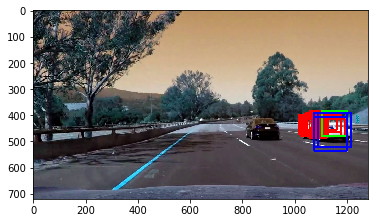

In [125]:
import time
%matplotlib inline
draw_img = test_imgs[10].copy()
t1 = time.time()
for scale, color in zip([1,1.5,2],[(255,0,0),(0,255,0),(0,0,255)]):
    heatmap, bboxes, draw_img = tracker.detect_cars(draw_img,360,550,0,1280,
                    init_size=(64,64), scale=scale, step=0.125, color=color)
print(time.time()-t1)
plt.imshow(draw_img)

# Train classifier

## Data observation

In [31]:
VEHICLES_PATH = './vehicles/vehicles/'
NONVEHICLES_PATH = './non-vehicles/non-vehicles/'

In [32]:
vehicle_files = [os.path.join(VEHICLES_PATH, x, y) for\
                 x in os.listdir(VEHICLES_PATH) for y in os.listdir(os.path.join(VEHICLES_PATH,x)) if y!='.DS_Store']

In [33]:
nonvehicle_files = [os.path.join(NONVEHICLES_PATH, x, y) for\
                 x in os.listdir(NONVEHICLES_PATH) if x!='.DS_Store' for y in os.listdir(os.path.join(NONVEHICLES_PATH,x)) if y!='.DS_Store']

In [232]:
len(vehicle_files), len(nonvehicle_files)

(8792, 8968)

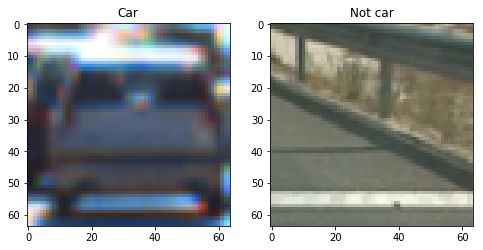

In [16]:
%matplotlib inline
vehicle = cv2.imread(vehicle_files[30])
nonvehicle = cv2.imread(nonvehicle_files[0])
fig = plt.figure(figsize=(8,6))
a = fig.add_subplot(1,2,1, title='Car')
plt.imshow(cv2.cvtColor(vehicle, cv2.COLOR_BGR2RGB))
a = fig.add_subplot(1,2,2, title='Not car')
plt.imshow(cv2.cvtColor(nonvehicle, cv2.COLOR_BGR2RGB))

In [286]:
feature_extractor = FeatureExtractor( feature_types=['HOG'],
                 hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=12,
                hog_params=((cv2.COLOR_BGR2HLS,[0]),(cv2.COLOR_BGR2RGB,[0])),
                color_transform=cv2.COLOR_BGR2RGB, spat_size=(16,16),
                hist_channels=[0,1,2], hist_nbins=32, hist_bins_range=(0,256))

In [45]:
vehicle_features, vehicle_labels = feature_extractor.return_features_and_labels(vehicle_files, 1)

In [46]:
nonvehicle_features, nonvehicle_labels = feature_extractor.return_features_and_labels(nonvehicle_files, 0)

In [48]:
vehicle_features.shape, nonvehicle_features.shape

((8792, 4392), (8968, 4392))

In [49]:
import pickle
vehicles = dict()
nonvehicles = dict()
vehicles['features'] = vehicle_features
vehicles['labels'] = vehicle_labels
nonvehicles['features'] = nonvehicle_features
nonvehicles['labels'] = nonvehicle_labels
saving_path = './data/hog_HLS_0_RGB_0_spat_16_16'
if not os.path.exists(saving_path):
    os.mkdir(saving_path)
with open(os.path.join(saving_path, 'vehicles.p'), 'wb') as f:
    pickle.dump(vehicles, f)
with open(os.path.join(saving_path, 'nonvehicles.p'), 'wb') as f:
    pickle.dump(nonvehicles, f)

## Train classifier

In [35]:
from sklearn.model_selection import train_test_split

In [32]:
saving_path = './data/hog_HLS_0_RGB_0_spat_16_16'
import pickle
with open(os.path.join(saving_path, 'vehicles.p'), 'rb') as f:
    vehicles=pickle.load( f)
with open(os.path.join(saving_path, 'nonvehicles.p'), 'rb') as f:
    nonvehicles=pickle.load( f)
vehicle_features = vehicles['features']
vehicle_labels = vehicles['labels']
nonvehicle_features = nonvehicles['features']
nonvehicle_labels = nonvehicles['labels']

In [33]:
print(vehicle_features.shape)
print(nonvehicle_features.shape)

(8792, 4392)
(8968, 4392)


In [36]:
vehicles_train_features, vehicles_test_features, vehicles_train_labels,  vehicle_test_labels = train_test_split(
    vehicle_features, vehicle_labels, test_size=0.2, random_state=123)

In [37]:
nonvehicles_train_features, nonvehicles_test_features, nonvehicles_train_labels, nonvehicles_test_labels = train_test_split(
    nonvehicle_features, nonvehicle_labels, test_size=0.2, random_state=123)

In [38]:
train_features = np.vstack([vehicles_train_features, nonvehicles_train_features])
train_labels = np.concatenate((vehicles_train_labels, nonvehicles_train_labels))
test_features = np.vstack([vehicles_test_features, nonvehicles_test_features])
test_labels = np.concatenate((vehicle_test_labels, nonvehicles_test_labels))

In [39]:
train_features.shape, test_features.shape

((14207, 4392), (3553, 4392))

In [40]:
train_labels.shape, test_labels.shape

((14207,), (3553,))

In [41]:
from sklearn.utils import shuffle

In [42]:
train_features, train_labels = shuffle(train_features, train_labels)

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features_scaled = scaler.transform(train_features)

In [45]:
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [46]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [52]:
kf = KFold(n_splits=3)
estimator = DecisionTreeClassifier()
param_grid = {'criterion':['gini', 'entropy'], 'splitter':['best', 'random'], 'max_depth':[5,7,10,None],
             'min_samples_split':[2,4,16,32,64]}
scorer = make_scorer(accuracy_score)
clf = RandomizedSearchCV(estimator, param_grid, n_iter=40, cv=kf, scoring=scorer, verbose=1, n_jobs=3)
clf.fit(train_features_scaled, train_labels)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  4.9min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed: 14.0min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
          error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=40, n_jobs=3,
          param_distributions={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [5, 7, 10, None], 'min_samples_split': [2, 4, 16, 32, 64]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(accuracy_score),
          verbose=1)

In [53]:
clf.best_score_

0.95009502357992537

In [55]:
tree_classifier = clf.best_estimator_

In [57]:
with open(os.path.join(saving_path, 'tree_clf.p'), 'wb') as f:
    pickle.dump(tree_classifier, f)

In [58]:
# estimate accuracy
test_features_scaled = scaler.transform(test_features)

In [59]:
with open(os.path.join(saving_path, 'scl.p'), 'wb') as f:
    pickle.dump(scaler, f)

In [60]:
predictions = tree_classifier.predict(test_features_scaled)

In [61]:
accuracy_score(test_labels, predictions)

0.95468618069237265

In [62]:
importances = tree_classifier.feature_importances_

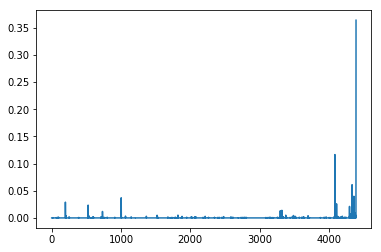

In [65]:
plt.plot(importances)

In [67]:
sorted_importances = np.sort(importances)

In [68]:
sorted_importances

array([ 0.        ,  0.        ,  0.        , ...,  0.06107416,
        0.1165595 ,  0.3636985 ])

In [70]:
7*7*2*2*9*2

3528

In [71]:
16*16*3

768

In [72]:
32*3

96

In [73]:
7*7*2*2*9*2+16*16*3+32*3

4392

In [76]:
print('hog total importance %f' % np.sum(importances[0:3528]))
print('spatial total importance %f' % np.sum(importances[3528:(3529+768)]))
print('histogram total importance %f' % np.sum(importances[:-96]))

hog total importance 0.265705
spatial total importance 0.185425
histogram total importance 0.451130


#### Histogram is the most important features, try to reconstruct feature vector

In [287]:
feature_extractor_short = FeatureExtractor( feature_types=['HOG',],
                 hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=12,
                hog_params=[(cv2.COLOR_BGR2YCrCb,[0])],
                color_transform=cv2.COLOR_BGR2RGB, spat_size=(16,16),
                hist_channels=[0,1,2], hist_nbins=64, hist_bins_range=(0,256))

In [234]:
hard_nonvehicle_path = './negative/'
hard_nonvehicle_files = [os.path.join(hard_nonvehicle_path, x) for x in os.listdir(hard_nonvehicle_path)]

In [235]:
len(hard_nonvehicle_files)

923

In [236]:
nonvehicle_files.extend(hard_nonvehicle_files)

In [237]:
len(nonvehicle_files)

9891

In [288]:
vehicle_features, vehicle_labels = feature_extractor_short.return_features_and_labels(vehicle_files, 1)
nonvehicle_features, nonvehicle_labels = feature_extractor_short.return_features_and_labels(nonvehicle_files, 0)

In [290]:
vehicle_features.shape, nonvehicle_features.shape

((8792, 2352), (9891, 2352))

In [292]:
#stoped here 7*7*2*2*12

In [293]:
vehicles_train_features, vehicles_test_features, vehicles_train_labels,  vehicle_test_labels = train_test_split(
    vehicle_features, vehicle_labels, test_size=0.2, random_state=123)
nonvehicles_train_features, nonvehicles_test_features, nonvehicles_train_labels, nonvehicles_test_labels = train_test_split(
    nonvehicle_features, nonvehicle_labels, test_size=0.2, random_state=123)

train_features = np.vstack([vehicles_train_features, nonvehicles_train_features])
train_labels = np.concatenate((vehicles_train_labels, nonvehicles_train_labels))
test_features = np.vstack([vehicles_test_features, nonvehicles_test_features])
test_labels = np.concatenate((vehicle_test_labels, nonvehicles_test_labels))

train_features, train_labels = shuffle(train_features, train_labels)

scaler = StandardScaler()
scaler.fit(train_features)
train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

print(train_features.shape, test_features.shape)

(14945, 2352) (3738, 2352)


In [86]:
kf = KFold(n_splits=3)
estimator = DecisionTreeClassifier()
param_grid = {'criterion':['gini', 'entropy'], 'splitter':['best', 'random'], 'max_depth':[5,7,10,None],
             'min_samples_split':[2,4,16,32,64]}
scorer = make_scorer(accuracy_score)
clf = RandomizedSearchCV(estimator, param_grid, n_iter=40, cv=kf, scoring=scorer, verbose=2, n_jobs=3)
clf.fit(train_features_scaled, train_labels)
tree_classifier_short = clf.best_estimator_
preds = tree_classifier_short.predict(test_features_scaled)
print('accuracy %f' % accuracy_score(test_labels, preds))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] splitter=random, min_samples_split=64, max_depth=None, criterion=entropy 
[CV] splitter=random, min_samples_split=64, max_depth=None, criterion=entropy 
[CV] splitter=random, min_samples_split=64, max_depth=None, criterion=entropy 
[CV]  splitter=random, min_samples_split=64, max_depth=None, criterion=entropy, total=   1.5s
[CV] splitter=random, min_samples_split=64, max_depth=10, criterion=gini 
[CV]  splitter=random, min_samples_split=64, max_depth=None, criterion=entropy, total=   1.6s
[CV] splitter=random, min_samples_split=64, max_depth=10, criterion=gini 
[CV]  splitter=random, min_samples_split=64, max_depth=None, criterion=entropy, total=   1.8s
[CV] splitter=random, min_samples_split=64, max_depth=10, criterion=gini 
[CV]  splitter=random, min_samples_split=64, max_depth=10, criterion=gini, total=   1.8s
[CV] splitter=random, min_samples_split=2, max_depth=7, criterion=entropy 
[CV]  splitter=random, min_sample

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.4min


[CV]  splitter=best, min_samples_split=16, max_depth=10, criterion=gini, total=  18.6s
[CV] splitter=random, min_samples_split=2, max_depth=None, criterion=gini 
[CV]  splitter=random, min_samples_split=2, max_depth=None, criterion=gini, total=   2.0s
[CV] splitter=best, min_samples_split=64, max_depth=5, criterion=gini 
[CV]  splitter=random, min_samples_split=2, max_depth=None, criterion=gini, total=   2.0s
[CV] splitter=best, min_samples_split=64, max_depth=5, criterion=gini 
[CV]  splitter=random, min_samples_split=2, max_depth=None, criterion=gini, total=   2.5s
[CV] splitter=best, min_samples_split=64, max_depth=5, criterion=gini 
[CV]  splitter=best, min_samples_split=64, max_depth=5, criterion=gini, total=  10.2s
[CV] splitter=random, min_samples_split=16, max_depth=None, criterion=entropy 
[CV]  splitter=best, min_samples_split=64, max_depth=5, criterion=gini, total=  10.3s
[CV] splitter=random, min_samples_split=16, max_depth=None, criterion=entropy 
[CV]  splitter=best, min_

[CV] splitter=random, min_samples_split=32, max_depth=10, criterion=gini 
[CV]  splitter=random, min_samples_split=64, max_depth=7, criterion=gini, total=   1.3s
[CV] splitter=random, min_samples_split=32, max_depth=10, criterion=gini 
[CV]  splitter=random, min_samples_split=32, max_depth=10, criterion=gini, total=   1.7s
[CV] splitter=random, min_samples_split=2, max_depth=10, criterion=gini 
[CV]  splitter=random, min_samples_split=32, max_depth=10, criterion=gini, total=   1.7s
[CV] splitter=random, min_samples_split=2, max_depth=10, criterion=gini 
[CV]  splitter=random, min_samples_split=32, max_depth=10, criterion=gini, total=   1.8s
[CV] splitter=random, min_samples_split=2, max_depth=10, criterion=gini 
[CV]  splitter=random, min_samples_split=2, max_depth=10, criterion=gini, total=   1.6s
[CV] splitter=best, min_samples_split=4, max_depth=None, criterion=entropy 
[CV]  splitter=random, min_samples_split=2, max_depth=10, criterion=gini, total=   1.6s
[CV] splitter=best, min_sa

[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  7.7min finished


accuracy 0.956375


In [89]:
tree_classifier_short

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [264]:
from sklearn.metrics import f1_score

In [ ]:
kf = KFold(n_splits=3)
estimator = RandomForestClassifier()
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[50,100,200], 'max_depth':[5,7,10,None],
             'min_samples_split':[2,4,16,32,64]}
scorer = make_scorer(f1_score)
clf = RandomizedSearchCV(estimator, param_grid, n_iter=30, cv=kf, scoring=scorer, verbose=1, n_jobs=3)
clf.fit(train_features_scaled, train_labels)
rand_tree_classifier_short = clf.best_estimator_
preds = rand_tree_classifier_short.predict(test_features_scaled)
print('accuracy %f' % accuracy_score(test_labels, preds))
print('f1 score %f' %f1_score(test_labels, preds))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [268]:
rand_tree_classifier_short

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [269]:
preds = rand_tree_classifier_short.predict(test_features_scaled)
print('accuracy %f' % accuracy_score(test_labels, preds))
print('f1 score %f' %f1_score(test_labels, preds))

accuracy 0.991974
f1 score 0.991429


In [ ]:
from sklearn.metrics import precision_score
kf = KFold(n_splits=3)
estimator = RandomForestClassifier()
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[50,100,200], 'max_depth':[5,7,10,None],
             'min_samples_split':[2,4,16,32,64]}
scorer = make_scorer(precision_score)
clf_prec = RandomizedSearchCV(estimator, param_grid, n_iter=120, cv=kf, scoring=scorer, verbose=1, n_jobs=3)
clf_prec.fit(train_features_scaled, train_labels)
rand_tree_classifier_short_prec = clf_prec.best_estimator_
preds = rand_tree_classifier_short_prec.predict(test_features_scaled)
print('accuracy %f' % accuracy_score(test_labels, preds))
print('f1 score %f' %f1_score(test_labels, preds))
print('precision score %f' % precision_score(test_labels, preds))

In [270]:
preds = rand_tree_classifier_short_prec.predict(test_features_scaled)
print('accuracy %f' % accuracy_score(test_labels, preds))
print('f1 score %f' %f1_score(test_labels, preds))
print('precision score %f' % precision_score(test_labels, preds))

accuracy 0.990102
f1 score 0.989407
precision score 0.996540


In [199]:
rand_tree_classifier_short

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [202]:
preds = rand_tree_classifier_short.predict(test_features_scaled)
print('accuracy %f' % accuracy_score(test_labels, preds))

accuracy 0.988742


In [162]:
os.mkdir('./data/rfc')

In [205]:
os.mkdir('./data/rfc/hog_YCrCb_0_spat_16_16_hist_RGB_64')

In [206]:
dpath = './data/rfc/hog_YCrCb_0_spat_16_16_hist_RGB_64'
with open(os.path.join(dpath, 'clf.p'), 'wb') as f:
    pickle.dump(rand_tree_classifier_short, f)
with open(os.path.join(dpath, 'scl.p'), 'wb') as f:
    pickle.dump(scaler, f)

In [145]:
import pandas as pd

In [146]:
df = pd.DataFrame(clf.cv_results_)

In [273]:
from sklearn.metrics import precision_score
kf = KFold(n_splits=3)
estimator = SVC()
param_grid = {'C':[0.001, 0.005,0.01,0.1,0.5,1,5,10], 'kernel':['linear'], 'decision_function_shape':['ovo', 'ovr']}
scorer = make_scorer(precision_score)
clf_prec = RandomizedSearchCV(estimator, param_grid, n_iter=16, cv=kf, scoring=scorer, verbose=1, n_jobs=3)
clf_prec.fit(train_features_scaled, train_labels)
SVC_classifier_short_prec = clf_prec.best_estimator_
preds = SVC_classifier_short_prec.predict(test_features_scaled)
print('accuracy %f' % accuracy_score(test_labels, preds))
print('f1 score %f' %f1_score(test_labels, preds))
print('precision score %f' % precision_score(test_labels, preds))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed: 23.1min finished


accuracy 0.983681
f1 score 0.982656
precision score 0.982935


## Improve accuracy by augmentation

In [95]:
import imgaug as ia
from imgaug import augmenters as iaa

In [96]:
# make augmented dataset
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        iaa.Fliplr(1), # horizontally flip 50% of all images
        sometimes(iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 3),
            [
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.ContrastNormalization((0.5, 1.5)), # improve or worsen the contrast
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [97]:
aug_vehicle_path = './vehicles_aug'
aug_nonvehicle_path = './nonvehicles_aug'
for p in [aug_vehicle_path, aug_nonvehicle_path]:
    if not os.path.exists(p):
        os.mkdir(p)

In [107]:
vehicle_images = [cv2.imread(x) for x in vehicle_files]
nonvehicle_images = [cv2.imread(x) for x in nonvehicle_files]

In [108]:
len(vehicle_images), len(nonvehicle_images)

(8792, 8968)

In [112]:
aug_vehicle_images = seq.augment_images(vehicle_images)
aug_nonvehicle_images = seq.augment_images(nonvehicle_images)

In [113]:
for path, collection in zip([aug_vehicle_path, aug_nonvehicle_path], [aug_vehicle_images, aug_nonvehicle_images]):
    for i, im in enumerate(collection):
        cv2.imwrite(os.path.join(path, str(i)+'.jpg'), im)

In [114]:
vehicle_files_aug = [os.path.join(aug_vehicle_path, x) for x in os.listdir(aug_vehicle_path)]
nonvehicle_files_aug = [os.path.join(aug_nonvehicle_path, x) for x in os.listdir(aug_nonvehicle_path)]

In [116]:
len(vehicle_files_aug), len(nonvehicle_files_aug)

(8792, 8968)

In [117]:
vehicle_files_joint = vehicle_files.copy()
vehicle_files_joint.extend(vehicle_files_aug)

In [118]:
nonvehicle_files_joint = nonvehicle_files.copy()
nonvehicle_files_joint.extend(nonvehicle_files_aug)

In [120]:
len(vehicle_files_joint), len(nonvehicle_files_joint)

(17584, 17936)

In [121]:
vehicle_features_j, vehicle_labels_j = feature_extractor_short.return_features_and_labels(vehicle_files_joint, 1)
nonvehicle_features_j, nonvehicle_labels_j = feature_extractor_short.return_features_and_labels(nonvehicle_files_joint, 0)

In [122]:
print(vehicle_features_j.shape, nonvehicle_features_j.shape)

(17584, 1956) (17936, 1956)


In [123]:
vehicles_train_features_j, vehicles_test_features_j, vehicles_train_labels_j,  vehicle_test_labels_j = train_test_split(
    vehicle_features_j, vehicle_labels_j, test_size=0.2, random_state=123)
nonvehicles_train_features_j, nonvehicles_test_features_j, nonvehicles_train_labels_j, nonvehicles_test_labels_j = train_test_split(
    nonvehicle_features_j, nonvehicle_labels_j, test_size=0.2, random_state=123)

train_features_j = np.vstack([vehicles_train_features_j, nonvehicles_train_features_j])
train_labels_j = np.concatenate((vehicles_train_labels_j, nonvehicles_train_labels_j))
test_features_j = np.vstack([vehicles_test_features_j, nonvehicles_test_features_j])
test_labels_j = np.concatenate((vehicle_test_labels_j, nonvehicles_test_labels_j))

train_features_j, train_labels_j = shuffle(train_features_j, train_labels_j)
scaler_j = StandardScaler()
scaler_j.fit(train_features_j)
train_features_scaled_j = scaler_j.transform(train_features_j)
test_features_scaled_j = scaler_j.transform(test_features_j)

print(train_features_j.shape, test_features_j.shape)
print(train_labels_j.shape, test_labels_j.shape)

(28415, 1956) (7105, 1956)
(28415,) (7105,)


In [124]:
kf = KFold(n_splits=3)
estimator = RandomForestClassifier()
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[10,20,50], 'max_depth':[5,7,10,None],
             'min_samples_split':[2,4,16,32,64]}
scorer = make_scorer(accuracy_score)
clf = RandomizedSearchCV(estimator, param_grid, n_iter=40, cv=kf, scoring=scorer, verbose=1, n_jobs=3)
clf.fit(train_features_scaled_j, train_labels_j)
rand_tree_classifier_short_j = clf.best_estimator_
preds = rand_tree_classifier_short_j.predict(test_features_scaled_j)
print('accuracy %f' % accuracy_score(test_labels_j, preds))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed: 13.6min finished


accuracy 0.945109


In [125]:
preds = rand_tree_classifier_short_j.predict(test_features_scaled)
print('accuracy %f' % accuracy_score(test_labels, preds))

accuracy 0.968477


## Test tracker

In [27]:
% matplotlib inline
test_path = './from_test_video/'
test_files = [os.path.join(test_path, x) for x in os.listdir(test_path) if x.endswith('.jpg')]
test_imgs = [cv2.imread(x) for x in test_files]

In [241]:
svc_clf = SVC()
svc_clf.fit(train_features_scaled, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [243]:
rfc_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rfc_clf.fit(train_features_scaled, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [244]:
t1 = time.time()
preds = svc_clf.predict(test_features_scaled)
print('SVC accuracy %f' % accuracy_score(test_labels, preds))
print('time elapsed %f' % time.time()-t1)

SVC accuracy 0.990102


TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [245]:
t1 = time.time()
preds = rfc_clf.predict(test_features_scaled)
print('RFC accuracy %f' % accuracy_score(test_labels, preds))
print('time elaples %f' % time.time()-t1)

RFC accuracy 0.991974


TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [278]:
feature_extractor_short = FeatureExtractor( feature_types=['HOG','SPAT','HIST'],
                 hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=9,
                hog_params=[(cv2.COLOR_BGR2YCrCb,[0])],
                color_transform=cv2.COLOR_BGR2RGB, spat_size=(16,16),
                hist_channels=[0,1,2], hist_nbins=64, hist_bins_range=(0,256),hog_method='smart')
tracker = Tracker(rand_tree_classifier_short_prec, feature_extractor_short, scaler, scale_dict={}, max_to_keep = 5,
                 heat_threshold=3, single_threshold=1, init_size=(64,64), step=0.25)

0.9236023426055908


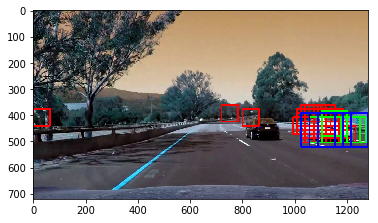

In [285]:
import time
draw_img = test_imgs[10].copy()
t1 = time.time()
for scale, color in zip([1,1.5,2],[(255,0,0),(0,255,0),(0,0,255)]):
    heatmap, bboxes, draw_img = tracker.detect_cars(draw_img,360,550,0,1280,
                    init_size=(64,64), scale=scale, step=0.25, color=color)
print(time.time()-t1)
plt.imshow(draw_img)

In [189]:
int(time.time()*10000)

15289014635340

#### Hard negative mining

In [222]:
hard_negative_folder_svc = './from_test_video/hard_svc'
detected_folder = './from_test_video/detected'
for f in [hard_negative_folder_svc, detected_folder]:
    if not os.path.exists(f):
        os.mkdir(f)
cntr=0
for img in test_imgs:
    for scale, color in zip([1,1.5,2],[(255,0,0),(0,255,0),(0,0,255)]):
        _, bboxes, draw_img = tracker2.detect_cars(img,360,550,600,1280,
                    init_size=(64,64), scale=scale, step=0.125, color=color)
        cntr+=1
        cv2.imwrite(os.path.join(detected_folder, str(cntr)+'.jpg'), draw_img)
        for bbox in bboxes:
            x_start, y_start, x_end, y_end = bbox
            cut_img = img[y_start:y_end, x_start:x_end, :]
            cut_img = cv2.resize(cut_img, (64,64))
            im_name = str(int(time.time()*10000))+'.jpg'
            cv2.imwrite(os.path.join(hard_negative_folder_svc, im_name), cut_img)
            
print(len(os.listdir(hard_negative_folder)))

222


In [223]:
len(os.listdir(hard_negative_folder_svc))

13293

4.453027725219727


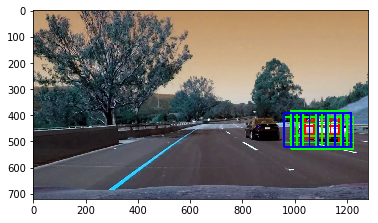

In [275]:
tracker2 = Tracker(SVC_classifier_short_prec, feature_extractor_short, scaler, scale_dict={}, max_to_keep = 5,
                 heat_threshold=3, single_threshold=2, init_size=(64,64), step=0.25)
draw_img2 = test_imgs[1].copy()
t1 = time.time()
for scale, color in zip([1,1.5,2],[(255,0,0),(0,255,0),(0,0,255)]):
    heatmap, bboxes, draw_img2 = tracker2.detect_cars(draw_img2,360,550,0,1280,
                    init_size=(64,64), scale=scale, step=0.25, color=color)
print(time.time()-t1)
plt.imshow(draw_img2)

## Make video

In [7]:
import pickle
saving_path = './data/aug'
with open(os.path.join(saving_path, 'clf.p'), 'rb') as f:
    classifier_j = pickle.load(f)
with open(os.path.join(saving_path, 'scl.p'), 'rb') as f:
    scaler_j = pickle.load(f)

In [6]:
scale_dict = {1:(360,550,300,1280), 2:(390,600,300,1280), 3:(400,720,300,1280)}
output = './output_videos/project_video_mk5_ht_3_scale_3.mp4'
feature_extractor = FeatureExtractor( feature_types=['HOG','SPAT','HIST'],
                 hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=9,
                hog_params=((cv2.COLOR_RGB2HLS,[0]),(None,[0])),
                color_transform=None, spat_size=(16,16),
                hist_channels=[0,1,2], hist_nbins=32, hist_bins_range=(0,256))
tracker = Tracker(classifier_j, feature_extractor, scaler_j, scale_dict, max_to_keep = 5,
                 heat_threshold=3, single_threshold=1, init_size=(64,64), step=0.5)
img_processor = tracker.track

clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(img_processor)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_mk5_ht_3_scale_3.mp4
[MoviePy] Writing video ./output_videos/project_video_mk5_ht_3_scale_3.mp4


100%|█████████▉| 1260/1261 [6:25:32<00:18, 18.36s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_mk5_ht_3_scale_3.mp4 

CPU times: user 6h 24min 39s, sys: 24.1 s, total: 6h 25min 3s
Wall time: 6h 25min 39s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [573]:
print(t2-t1)

53.8247389793396


In [366]:
import math

def return_sliding_features(img, ymin, ymax, xmin, xmax, feature_extractor, feature_types=['HOG', 'SPAT', 'HIST'],
                            init_size=(64,64), scale=1, step=0.125,
                           cell_size=8, hog_color_transform=cv2.COLOR_BGR2GRAY,
                           color_transform=None, spat_size=(32,32),
                           hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
    features = None
    for ftype in feature_types:
        if ftype == 'HOG':
            ft = return_sliding_hog(img, ymin, ymax, xmin, xmax, feature_extractor,
                                   init_size=init_size, scale=scale, step=step,
                                   cell_size=cell_size, hog_color_transform=hog_color_transform)
        elif ftype == 'SPAT':
            ft = return_sliding_spat(img, ymin, ymax, xmin, xmax, feature_extractor,
                                     init_size=init_size, scale=scale,
                                     step=step, color_transform=color_transform, spat_size=spat_size)
        elif ftype == 'HIST':
            ft = return_sliding_hist(img, ymin, ymax, xmin, xmax, feature_extractor,
                                     init_size=init_size, scale=scale, step=step,
                                     color_transform=color_transform, hist_channels=hist_channels,
                                     hist_nbins=hist_nbins, hist_bins_range=hist_bins_range)
        else:
            raise ValueError
        if features is None:
            features = ft
        else:
            features = np.hstack([features, ft])
    return features
    
def return_sliding_hog(img, ymin, ymax, xmin, xmax, feature_extractor, init_size=(64,64), scale=1, step=0.125, cell_size=8,
                         hog_color_transform=cv2.COLOR_BGR2GRAY):
    roi = img[ymin:ymax, xmin:xmax, :]
    dy = ymax-ymin
    dx = xmax-xmin
    dy_sc = int(dy/scale)
    dx_sc = int(dx/scale)
    x_init, y_init = init_size
    resized_img = cv2.resize(roi, (dx_sc,dy_sc))
    nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
    nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
    delta_index_y = math.floor(step*y_init/cell_size)
    delta_index_x = math.floor(step*x_init/cell_size)
    dy_hog = y_init//cell_size - 1
    dx_hog = x_init//cell_size - 1
    resized_hog = feature_extractor.return_features(resized_img, 'HOG',
                                                    hog_color_transform=cv2.COLOR_BGR2GRAY, hog_feature_vec=False)[0]
    window_features = []
    for i in range(nsteps_y):
        y_ind = i*delta_index_y
        for j in range(nsteps_x):
            x_ind = j*delta_index_x
            window_hog = resized_hog[y_ind:(y_ind+dy_hog),x_ind:(x_ind+dx_hog),:]
            window_features.append(window_hog.ravel())
            
    return np.array(window_features) #, np.array(window_imgs)

def return_sliding_spat(img, ymin, ymax, xmin, xmax, feature_extractor, init_size=(64,64), scale=1,
                        step=0.125, color_transform=None, spat_size=(32,32)):
    roi = img[ymin:ymax, xmin:xmax, :]
    dy = ymax-ymin
    dx = xmax-xmin
    dy_sc = int(dy/scale)
    dx_sc = int(dx/scale)
    x_init, y_init = init_size
    resized_img = cv2.resize(roi, (dx_sc,dy_sc))
    nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
    nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
    window_features = []
    for i in range(nsteps_y):
        for j in range(nsteps_x):
            window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
            features = feature_extractor.return_features(window_img, 'SPAT',
                                                        color_transform_flag=color_transform, spat_size=spat_size)[0]
            window_features.append(features)
    return np.array(window_features)

def return_sliding_hist(img, ymin, ymax, xmin, xmax, feature_extractor, init_size=(64,64), scale=1,
                        step=0.125, color_transform=None,hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
    roi = img[ymin:ymax, xmin:xmax, :]
    dy = ymax-ymin
    dx = xmax-xmin
    dy_sc = int(dy/scale)
    dx_sc = int(dx/scale)
    x_init, y_init = init_size
    resized_img = cv2.resize(roi, (dx_sc,dy_sc))
    nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
    nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
    window_features = []
    for i in range(nsteps_y):
        for j in range(nsteps_x):
            window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
            features = feature_extractor.return_features(window_img, 'HIST',
                                                        color_transform_flag=color_transform,
                                                        hist_channels=hist_channels, hist_nbins=hist_nbins,
                                                        hist_bins_range=hist_bins_range)[0]
            window_features.append(features)
    return np.array(window_features)

In [531]:
def draw_multiscale(img, heatmaps_, bboxes_scaled, threshold=None):
    draw_img = img.copy()
    heatmaps = heatmaps_.copy()
    if threshold is not None:
        heatmaps[heatmaps<=threshold]=0
    ones_heatmap = np.zeros_like(heatmaps)
    ones_heatmap[heatmaps>0] = 1
    labeled_map, labels = measurements.label(ones_heatmap)
    multiscale_heatmap = np.zeros_like(heatmaps)
    multiscale_bboxes = []
    for label_ in range(labels):
        yc, xc, sw = 0, 0, 0
        x_s, y_s = [], []
        selection = labeled_map.copy()
        selection[selection != (label_+1)] = 0
        rows, cols = np.nonzero(selection)
        pts = np.array([rows,cols]).T
        for pt in pts:
            w = heatmaps[pt[0], pt[1]]
            yc += pt[0]*w
            xc += pt[1]*w
            x_s.append(pt[1])
            y_s.append(pt[0])
            sw += w
        yc /= sw
        xc /= sw
        xmin = min(x_s)
        xmax = max(x_s)
        ymin = min(y_s)
        ymax = max(y_s)
        w_2 = min(abs(xmin-xc), abs(xmax-xc))
        h_2 = min(abs(ymin-yc), abs(ymax-yc))
        x1 = int(max(0,xc-w_2))
        x2 = int(min(img.shape[1], xc+w_2))
        y1 = int(max(0, yc-h_2))
        y2 = int(min(img.shape[0], yc+h_2))
        label_bbox = (x1,y1,x2,y2)
        print(label_bbox)
        multiscale_heatmap[y1:y2, x1:x2] = 1
        cv2.rectangle(draw_img, (x1,y1), (x2,y2), (0,255,0), 6)
        multiscale_bboxes.append(label_bbox)
    return multiscale_heatmap, multiscale_bboxes, draw_img
            
def detect_multiscale(img, scale_dict, feature_extractor, classifier, scaler, threshold=None, return_images=False,
                     feature_types=['HOG', 'SPAT', 'HIST'],
                        init_size=(64,64), step=0.125,
                        cell_size=8, hog_color_transform=cv2.COLOR_BGR2GRAY,
                        color_transform=None, spat_size=(32,32),
                        hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
    heatmaps = None
    draw_imgs = None
    bboxes_scaled = []
    for k,v in scale_dict.items():
        scale = k
        ymin, ymax, xmin, xmax = v
        heat, bbox, draw = detect_cars(img, ymin, ymax, xmin, xmax,
                feature_extractor, classifier, scaler, feature_types,
                init_size, scale, step,
                cell_size, hog_color_transform,
                color_transform, spat_size,
                hist_channels, hist_nbins, hist_bins_range)
        if heatmaps is None:
            heatmaps = heat*scale
        else:
            heatmaps += heat*scale
        if return_images:
            if draw_imgs is None:
                draw_imgs = draw[np.newaxis]
            else:
                draw_imgs = np.vstack([draw_imgs, draw[np.newaxis]])
        bboxes_scaled.append((scale,bbox))
    return heatmaps, bboxes_scaled, draw_imgs
        
    
def detect_cars(img, ymin, ymax, xmin, xmax,
                feature_extractor, classifier, scaler, feature_types=['HOG', 'SPAT', 'HIST'],
                init_size=(64,64), scale=1, step=0.125,
                cell_size=8, hog_color_transform=cv2.COLOR_BGR2GRAY,
                color_transform=None, spat_size=(32,32),
                hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
    features = return_sliding_features(img, ymin, ymax, xmin, xmax, feature_extractor, feature_types,
                            init_size, scale, step,
                           cell_size, hog_color_transform,
                           color_transform, spat_size,
                           hist_channels, hist_nbins, hist_bins_range)
    scaled_features = scaler.transform(features)
    predictions = classifier.predict(scaled_features)
    heatmap, bboxes, draw_img = draw_detections(img, ymin, ymax, xmin, xmax, predictions, init_size, scale, step)
    return heatmap, bboxes, draw_img

def draw_detections(img, ymin, ymax, xmin, xmax, predictions, init_size, scale, step):
    draw_img = img.copy()
    heatmap = np.zeros((img.shape[0], img.shape[1]))
    dy = ymax-ymin
    dx = xmax-xmin
    dy_sc = int(dy/scale)
    dx_sc = int(dx/scale)
    x_init, y_init = init_size
    nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
    nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
    pred = predictions.reshape(nsteps_y, nsteps_x)
    ywin = y_init*scale
    xwin = x_init*scale
    bboxes = []
    for i in range(nsteps_y):
        for j in range(nsteps_x):
            car = pred[i,j]
            if car == 1:
                x_start = int(xmin+j*x_init*scale*step)
                x_end = int(x_start + xwin)
                y_start = int(ymin + i*y_init*scale*step)
                y_end =int(y_start+ywin)
                cv2.rectangle(draw_img, (x_start, y_start), (x_end, y_end), (0,255,0), 6)
                heatmap[y_start:y_end, x_start:x_end] = 1
                bboxes.append((x_start, y_start, x_end, y_end))
    return heatmap, bboxes, draw_img
            

In [455]:
ary = np.zeros((10,10))
ary[3:6, 6:9]=1
np.nonzero(ary)

(array([3, 3, 3, 4, 4, 4, 5, 5, 5], dtype=int64),
 array([6, 7, 8, 6, 7, 8, 6, 7, 8], dtype=int64))

In [449]:
ary = np.zeros((3,128,128,3))
d = dict()
d[1]=1
d[2]=2
d[3]=3

In [423]:

step=0.5
classifier = clf.best_estimator_
im_scaler = scaler
hist_ch = [0,1,2]
ftypes = ['HOG', 'SPAT', 'HIST']
init_size = (64,64)
test_img = cv2.imread('./test_images/frame473.jpg')
features = return_sliding_features(test_img, ymin, ymax, xmin, xmax, feature_extractor, ftypes,
                           hist_channels=hist_ch, scale=scale, step=step)
sc_features = im_scaler.transform(features)
preds = classifier.predict(sc_features)

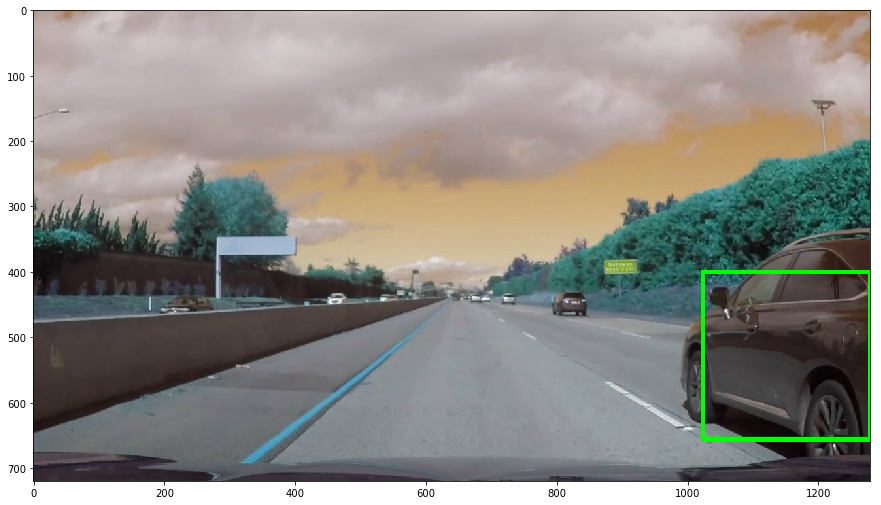

In [424]:
draw_img, heatmap = draw_detections(test_img, ymin, ymax, xmin, xmax, preds, (64,64), scale, step)
plt.figure(figsize=(15,10))
plt.imshow(draw_img)

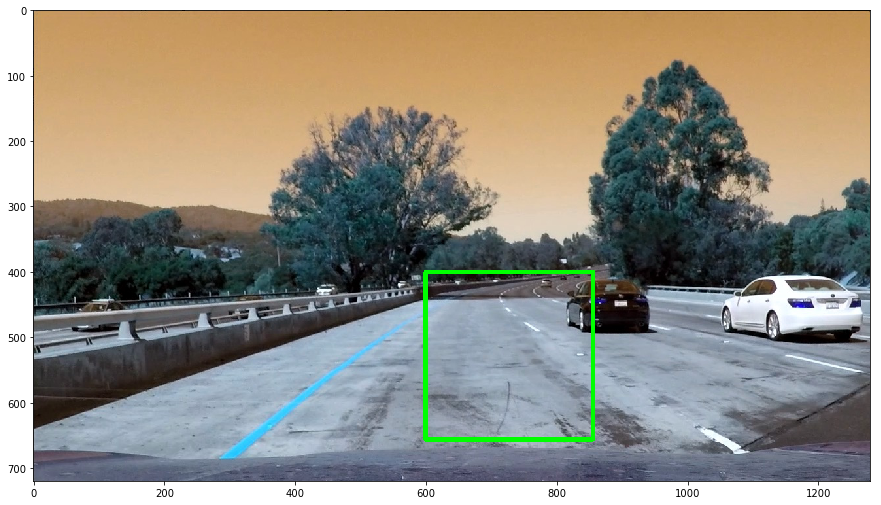

In [420]:
test_img_2 = cv2.imread(test_files[0])
scale = 4
cv2.rectangle(test_img_2,(600,400),(600+scale*64,400+scale*64), (0,255,0), 6)
plt.figure(figsize=(15,10))
plt.imshow(test_img_2)

In [459]:
scale_dict = {0.5:(360,450,0,1280), 1:(360,550,0,1280), 2:(390,600,0,1280)}#,3:(450,720,0,1280), 4:(450,720,0,1280)}
classifier = clf.best_estimator_
im_scaler = scaler
hist_ch = [0,1,2]
ftypes = ['HOG', 'SPAT', 'HIST']
init_size = (64,64)
test_img = cv2.imread(test_files[0])
heatmaps, bboxes_scaled, draw_imgs =  detect_multiscale(test_img, scale_dict, feature_extractor, classifier, im_scaler, threshold=None, return_images=True,
                     feature_types=['HOG', 'SPAT', 'HIST'],
                        init_size=init_size, step=0.5,
                        cell_size=8, hog_color_transform=cv2.COLOR_BGR2GRAY,
                        color_transform=None, spat_size=(32,32),
                        hist_channels=[0,1,2], hist_nbins=32, hist_bins_range=(0,256))


In [532]:
multiscale_heatmap, multiscale_bboxes, draw_img = draw_multiscale(test_img, heatmaps, bboxes_scaled)
#rows, cols= draw_multiscale(test_img, heatmaps, bboxes_scaled)

(1027, 391, 1279, 519)
(820, 390, 959, 508)


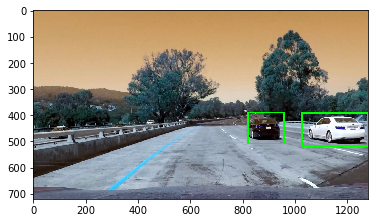

In [533]:
plt.imshow(draw_img)

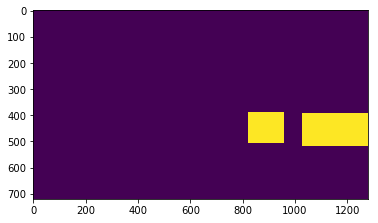

In [534]:
plt.imshow(multiscale_heatmap)

In [522]:
np.array([rows, cols]).T

array([[ 376, 1136],
       [ 376, 1137],
       [ 376, 1138],
       ..., 
       [ 519, 1277],
       [ 519, 1278],
       [ 519, 1279]], dtype=int64)

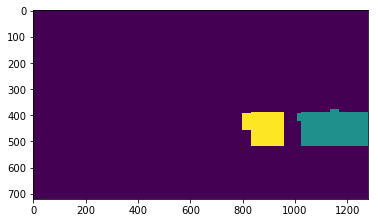

In [497]:
ones_heat = np.zeros_like(heatmaps)
ones_heat[heatmaps>0] = 1
new_ = measurements.label(heatmaps)[0]
plt.imshow(new_)

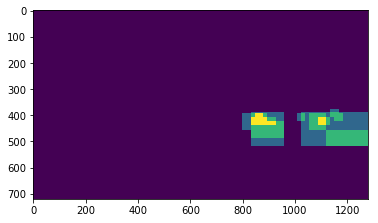

In [442]:
plt.imshow(heatmap)

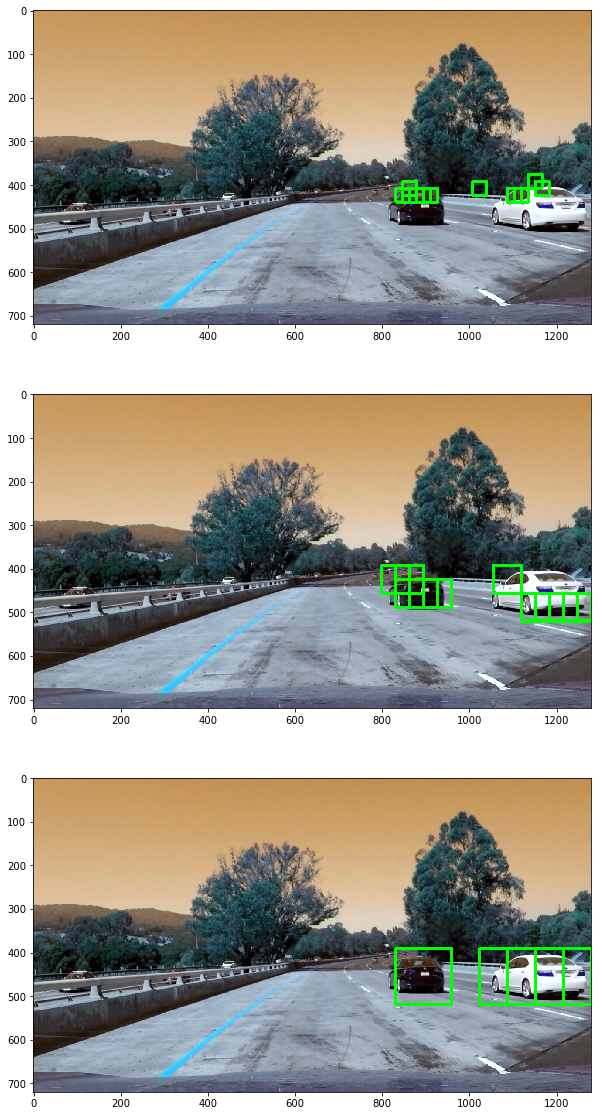

In [445]:
fig = plt.figure(figsize = (10,20))
for i,img in enumerate(imgs):
    a = fig.add_subplot(3,1,i+1)
    plt.imshow(img)
plt.show()

In [386]:
def apply_threshold(heatmap, threshold):
    ans = heatmap.copy()
    ans[ans <= threshold] = 0
    return ans

In [387]:
filtered = apply_threshold(heatmap, 1)

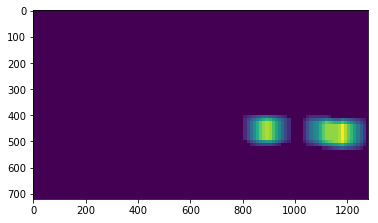

In [388]:
plt.imshow(filtered)

In [389]:
from scipy.ndimage.measurements import label

In [390]:
labels = label(filtered)

In [391]:
labels

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), 2)

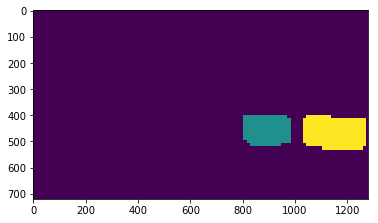

In [392]:
plt.imshow(labels[0])